In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.applications.efficientnet import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
import datetime

In [ ]:
import cv2 # 
import imghdr
from pathlib import Path

data_dir = 'dataset-type' 
image_extensions = ['jpeg', 'jpg', 'bmp', 'png', 'gif'] 

print(f"Memulai pemindaian di folder: {data_dir} ...")

bad_files = []

for root, dirs, files in os.walk(data_dir):
    for filename in files:
        file_path = os.path.join(root, filename)
        
        ext = filename.split('.')[-1].lower()
        
        if filename.startswith('.') or ext not in image_extensions:
            print(f"Menghapus file bukan gambar: {file_path}")
            os.remove(file_path)
            continue
            
        try:
            img_type = imghdr.what(file_path)
            if img_type is None:
                print(f"Format tidak dikenali: {file_path}")
                os.remove(file_path)
                bad_files.append(file_path)
                continue
        except Exception:
            print(f"Error membaca header: {file_path}")
            os.remove(file_path)
            continue
            
        try:
            img = cv2.imread(file_path)
            if img is None:
                print(f"Gambar corrupt/rusak: {file_path}")
                os.remove(file_path)
                bad_files.append(file_path)
        except Exception as e:
            print(f"File rusak parah: {file_path}")
            os.remove(file_path)
            bad_files.append(file_path)

In [ ]:
def deep_clean_images(root_dir):
    valid_ext = (".jpg", ".jpeg", ".png", ".bmp")
    removed = 0

    for root, _, files in os.walk(root_dir):
        for file in files:
            path = os.path.join(root, file)

            if not file.lower().endswith(valid_ext):
                print("REMOVE (ext):", path)
                os.remove(path)
                removed += 1
                continue

            if os.path.getsize(path) == 0:
                print("REMOVE (0 KB):", path)
                os.remove(path)
                removed += 1
                continue

            img = cv2.imread(path)
            if img is None:
                print("REMOVE (cv2 fail):", path)
                os.remove(path)
                removed += 1

    print(f"\nTotal file dihapus: {removed}")

deep_clean_images("dataset")



Total file dihapus: 0


In [ ]:
def reencode_images(root_dir):
    valid_ext = (".jpg", ".jpeg", ".png", ".bmp")
    fixed = 0
    removed = 0

    for root, _, files in os.walk(root_dir):
        for file in files:
            path = os.path.join(root, file)

            if not file.lower().endswith(valid_ext):
                continue

            img = cv2.imread(path)
            if img is None:
                print("REMOVE (cannot read):", path)
                os.remove(path)
                removed += 1
                continue

            try:
                cv2.imwrite(path, img)
                fixed += 1
            except:
                print("REMOVE (write fail):", path)
                os.remove(path)
                removed += 1

    print(f"\nFixed images: {fixed}")
    print(f"Removed images: {removed}")

reencode_images("dataset")



Fixed images: 1754
Removed images: 0


In [ ]:
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32
RANDOM_SEED = 42

data_dir = 'dataset-type'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

print("Loading Training Data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("Loading Validation Data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False 
)

print("Loading Test Data...")
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    
    layers.RandomRotation(0.2), 
    
    layers.RandomZoom(0.1),
    
    layers.RandomContrast(0.2),
    
    layers.RandomBrightness(0.1)
])

def preprocess_for_b0(image, label):
    return preprocess_input(image), label

train_ds = train_ds.map(preprocess_for_b0)
val_ds = val_ds.map(preprocess_for_b0)
test_ds = test_ds.map(preprocess_for_b0)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                        num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

print("\n--- Data Ready for EfficientNet-B0 ---")
for image_batch, labels_batch in train_ds.take(1):
  print(f"Image Batch Shape: {image_batch.shape}")
  print(f"Label Batch Shape: {labels_batch.shape}")
  break

Loading Training Data...
Found 1240 files belonging to 7 classes.
Loading Validation Data...
Found 337 files belonging to 7 classes.
Loading Test Data...
Found 177 files belonging to 7 classes.

--- Data Ready for EfficientNet-B0 ---
Image Batch Shape: (32, 224, 224, 3)
Label Batch Shape: (32,)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ModelCheckpoint

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False 

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=5,                 
    restore_best_weights=True, 
    verbose=1                  
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,                 
    callbacks=[early_stopping], 
    verbose=1
)


checkpoint = ModelCheckpoint(
    "modelB0-2 .keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                     

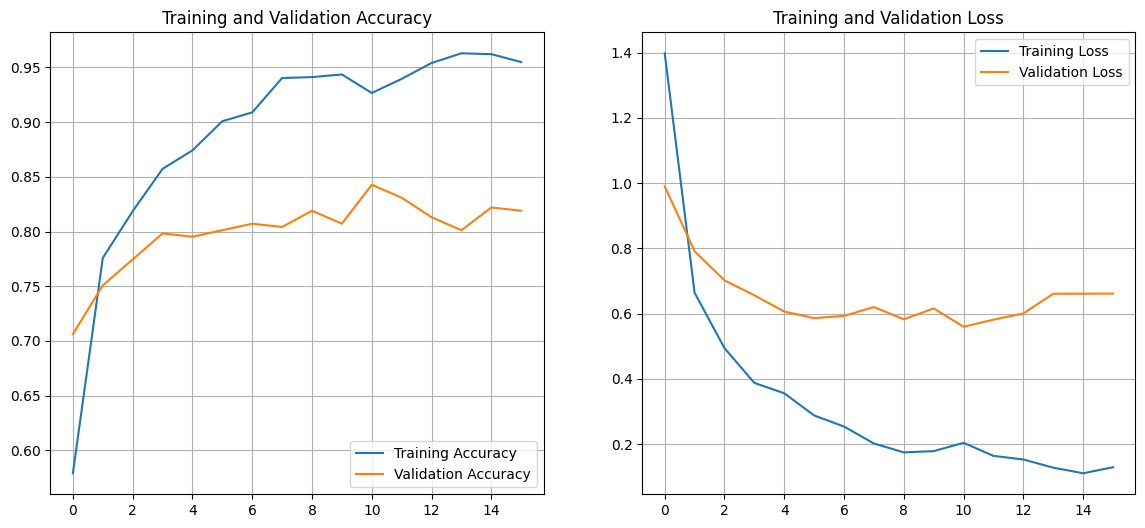

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.show()

plot_history(history)

Menggunakan Kelas: ['HDPE', 'LDPA', 'Other', 'PET', 'PP', 'PS', 'PVC']

--- Mengevaluasi pada Data Test ---
6/6 [==============================] - 2s 287ms/step - loss: 0.6841 - accuracy: 0.7966
Test Accuracy: 79.66%
Test Loss: 0.6841

Sedang memprediksi semua gambar test (harap tunggu)...
6/6 [==============================] - 2s 273ms/step

--- Classification Report ---
              precision    recall  f1-score   support

        HDPE       0.70      0.57      0.63        28
        LDPA       0.91      1.00      0.95        30
       Other       0.65      0.79      0.71        19
         PET       0.92      0.77      0.84        30
          PP       0.81      0.87      0.84        30
          PS       0.75      0.64      0.69        14
         PVC       0.76      0.85      0.80        26

    accuracy                           0.80       177
   macro avg       0.79      0.78      0.78       177
weighted avg       0.80      0.80      0.79       177



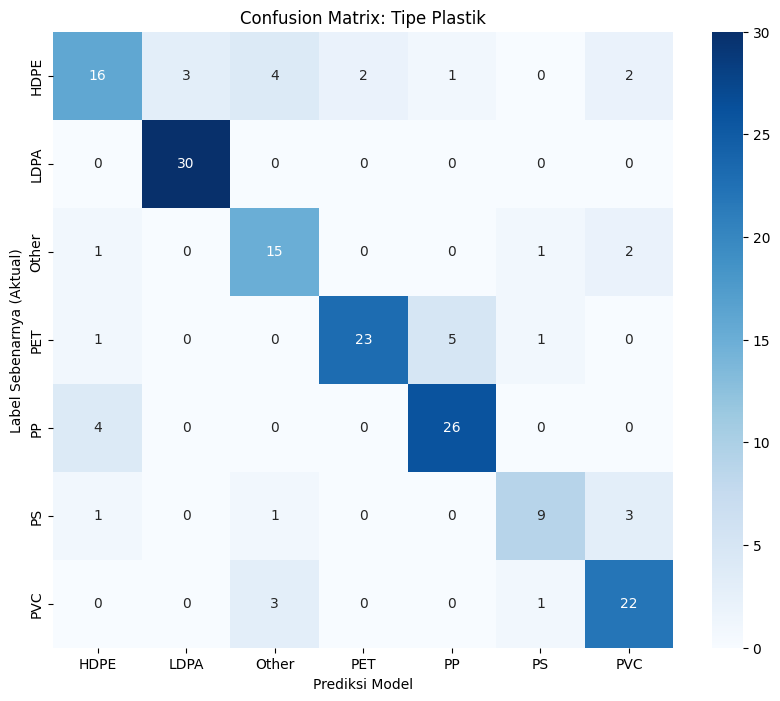

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

class_names = ['HDPE', 'LDPA', 'Other', 'PET', 'PP', 'PS', 'PVC']
print(f"Menggunakan Kelas: {class_names}")

print("\n--- Mengevaluasi pada Data Test ---")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

print("\nSedang memprediksi semua gambar test (harap tunggu)...")
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya (Aktual)')
plt.title('Confusion Matrix: Tipe Plastik')
plt.show()

1/1 [==============================] - 0s 312ms/step


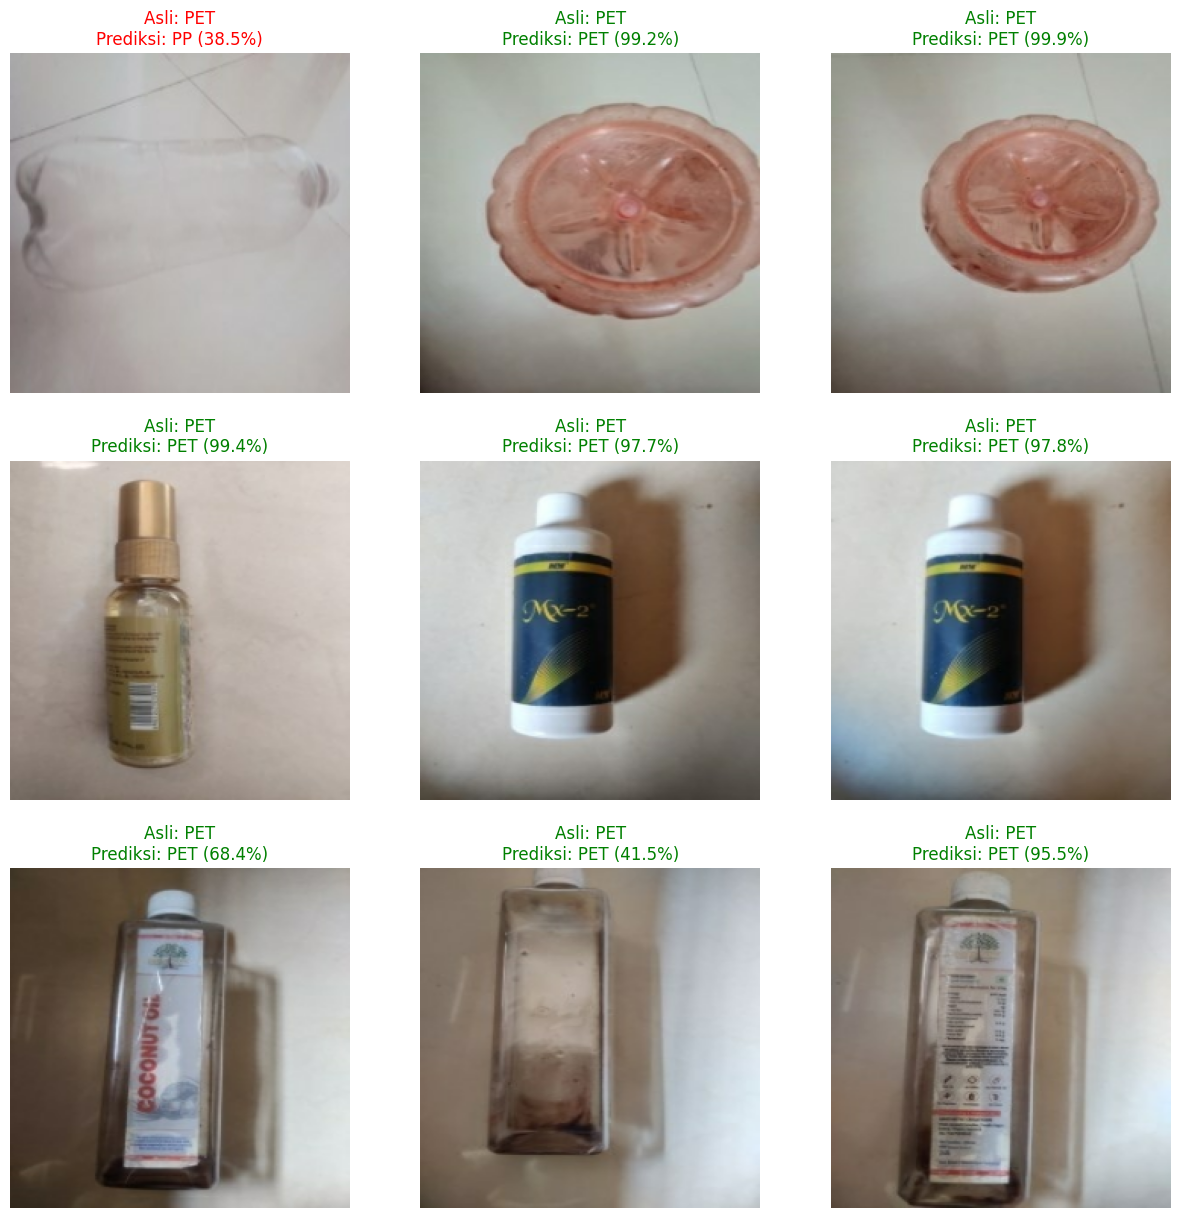

In [ ]:
def plot_random_prediction_samples(dataset, model, class_names):
    plt.figure(figsize=(15, 15))
    
    shuffled_ds = dataset.shuffle(buffer_size=1000)
    
    for images, labels in shuffled_ds.take(1):
        
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            
            img_array = images[i].numpy().astype("uint8")
            plt.imshow(img_array)
            
            true_label_idx = labels[i]
            pred_label_idx = pred_labels[i]
            
            true_txt = class_names[true_label_idx]
            pred_txt = class_names[pred_label_idx]
            
            confidence = 100 * np.max(preds[i])
            
            color = 'green' if true_label_idx == pred_label_idx else 'red'
            
            plt.title(f"Asli: {true_txt}\nPrediksi: {pred_txt} ({confidence:.1f}%)", 
                      color=color)
            plt.axis("off")
            
    plt.show()

plot_random_prediction_samples(test_ds, model, class_names)

In [ ]:
def plot_mixed_class_samples(dataset, model, class_names):
    num_classes = len(class_names)

    images_per_class = {}
    
    for images, labels in dataset:
        for img, lbl in zip(images, labels):
            lbl = int(lbl.numpy())
            if lbl not in images_per_class:
                images_per_class[lbl] = img
            if len(images_per_class) == num_classes:
                break
        if len(images_per_class) == num_classes:
            break

    images = tf.stack(list(images_per_class.values()))
    labels = np.array(list(images_per_class.keys()))

    idx = np.random.permutation(len(labels))
    images = tf.gather(images, idx)
    labels = labels[idx]

    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(15, 10))

    for i in range(len(images)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        true_txt = class_names[labels[i]]
        pred_txt = class_names[pred_labels[i]]
        conf = 100 * np.max(preds[i])

        color = "green" if labels[i] == pred_labels[i] else "red"
        plt.title(f"Asli: {true_txt}\nPred: {pred_txt} ({conf:.1f}%)", color=color)
        plt.axis("off")

    plt.show()


In [ ]:
plot_mixed_class_samples(test_ds, model, class_names)


1/1 [==============================] - 0s 83ms/step


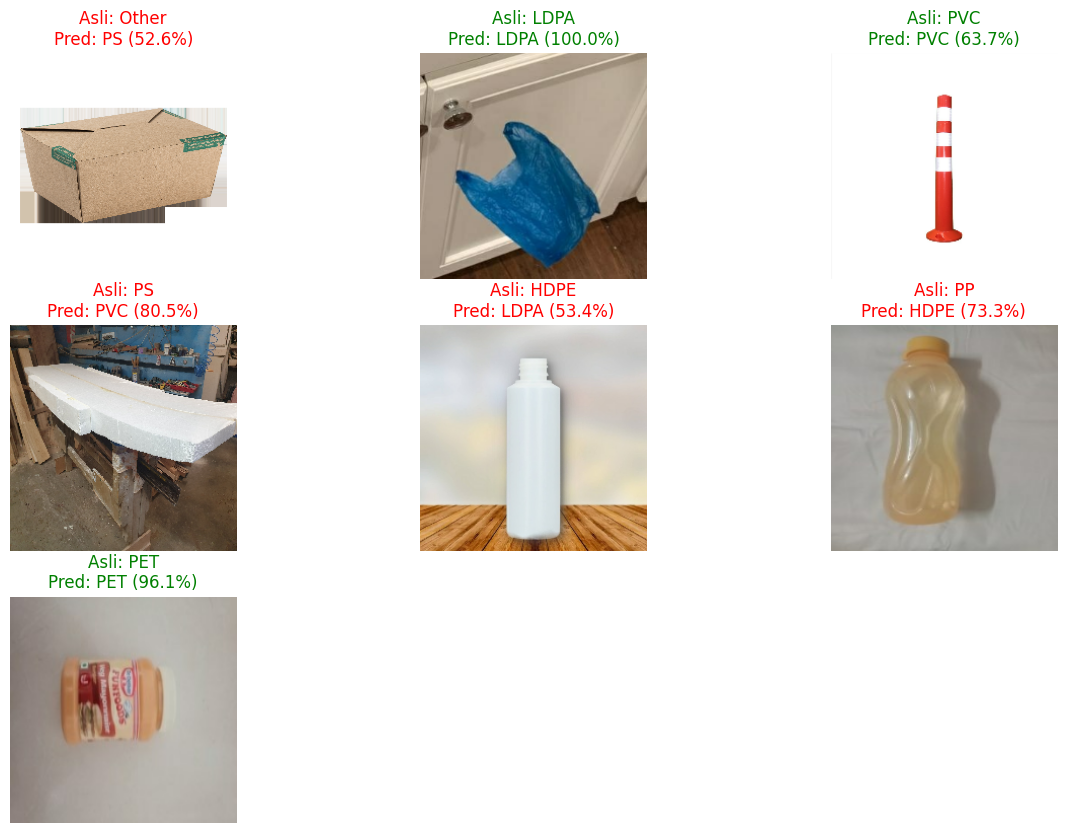

In [53]:
plot_mixed_class_samples(test_ds, model, class_names)
